# Well Dataset

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from ANFISpy import ANFIS

Loading the dataset:

In [2]:
SEED = 10
torch.manual_seed(SEED)

df = pd.read_excel('well_data.xls')
df = df.dropna()

FEATURES = ['espessura', 'resistividade']
TARGET = ['resistencia_transversal']

x = df[FEATURES].values.astype('float16')
y = df[TARGET].values.astype('float16')

Plotting the data:

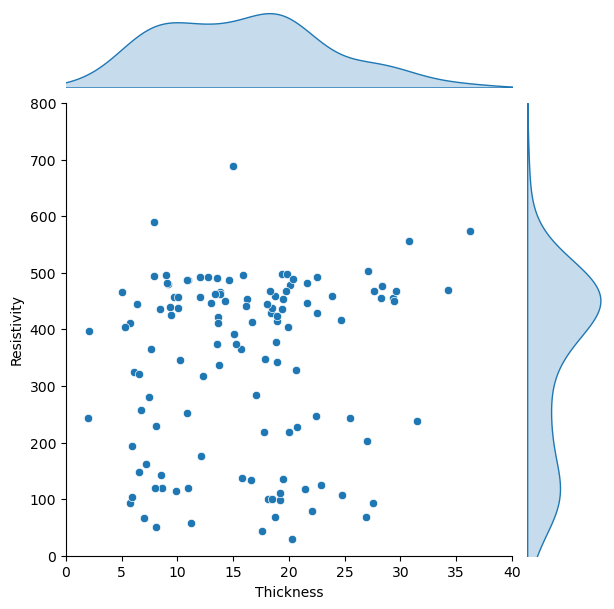

In [3]:
plot = sns.jointplot(
    x=x[:, 0],
    y=x[:, 1],
)

plot.ax_marg_x.clear()
sns.kdeplot(x=x[:, 0], ax=plot.ax_marg_x, fill=True)
plot.ax_marg_x.axis('off')

plot.ax_marg_y.clear()
sns.kdeplot(y=x[:, 1], ax=plot.ax_marg_y, fill=True, )
plot.ax_marg_y.axis('off')

plot.set_axis_labels('Thickness', 'Resistivity')
plt.xlim([0, 40])
plt.ylim([0, 800])

plt.show()

Train, test and validation split:

In [4]:
x, index = np.unique(x, axis=0, return_index=True)
y = y[index]

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.4, random_state=SEED)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=SEED)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

x_train_max = x_train.max(dim=0, keepdim=True)[0]
y_train_max = y_train.max(dim=0, keepdim=True)[0]
x_test_max = x_test.max(dim=0, keepdim=True)[0]
y_test_max = y_test.max(dim=0, keepdim=True)[0]
x_val_max = x_val.max(dim=0, keepdim=True)[0]
y_val_max = y_val.max(dim=0, keepdim=True)[0]

x_train /= x_train_max
y_train /= y_train_max
x_test /= x_test_max
y_test /= y_test_max
x_val /= x_val_max
y_val /= y_val_max

Creating the DataLoaders:

In [5]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Instantiating the model:

In [6]:
n_vars = 2
mf_names = [['L', 'M', 'H']]

variables = {
    'inputs': {
        'n_sets': [3, 3],
        'uod': n_vars * [(0, 1)],
        'var_names': ['Thickness', 'Resistivity'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': TARGET[0],
        'n_classes': 1,
    },
}

anfis = ANFIS(
    variables, 
    'gaussian', 
    and_operator=torch.prod, 
    output_activation=nn.ReLU(), 
    mean_rule_activation=True
)

model = torch.load('anfis.pth', map_location='cpu', weights_only=True)
anfis.load_state_dict(model)

<All keys matched successfully>

Plotting.

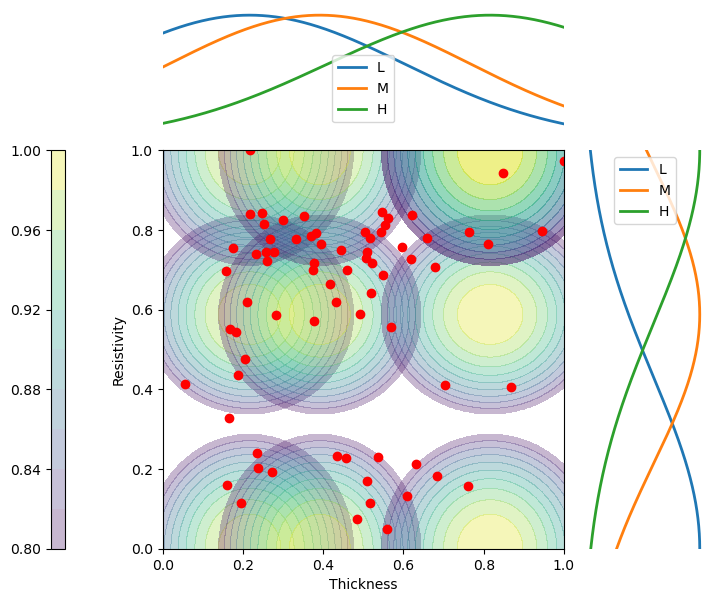

In [7]:
anfis.plot_rules(['Thickness', 'Resistivity'], thr=0.8, x_data=x_train[:, 0], y_data=x_train[:, 1])

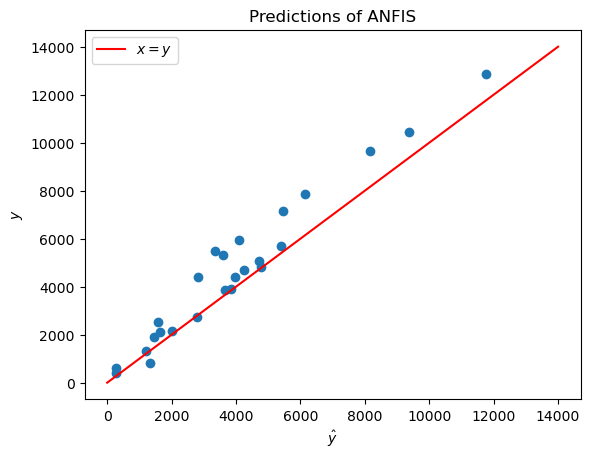

In [8]:
y_pred = anfis(x_test)

plt.scatter((y_pred * y_test_max).detach(), (y_test * y_test_max).detach())
plt.plot([0, 14000], [0, 14000], label=r'$x=y$', color='red')
plt.xlabel(r'$\hat y$')
plt.ylabel(r'$y$')
plt.title('Predictions of ANFIS')
plt.legend()
plt.show()

Plotting the membership functions of the model:

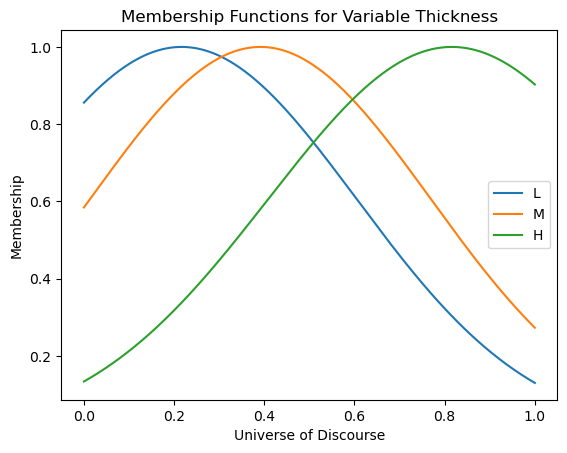

In [9]:
anfis.plot_var('Thickness')

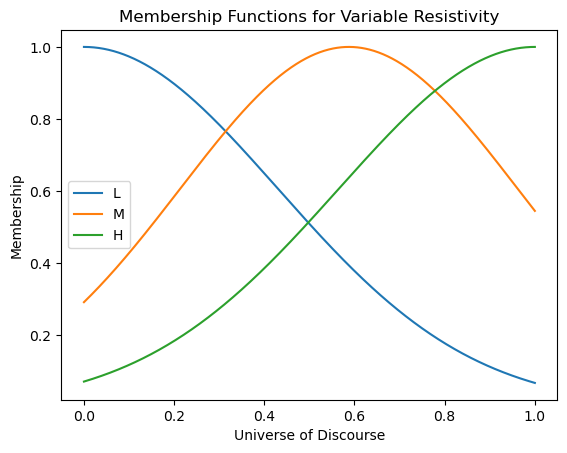

In [10]:
anfis.plot_var('Resistivity')

Plotting the output surface:

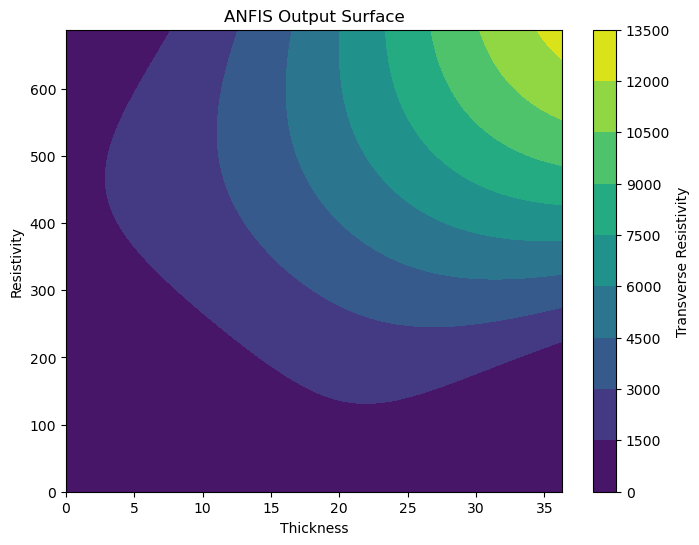

In [11]:
x_grid = np.linspace(0, 1, 100)
y_grid = np.linspace(0, 1, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

grid = torch.tensor(np.c_[X_grid.ravel(), Y_grid.ravel()], dtype=torch.float32)

with torch.no_grad():
    Z_grid = anfis(grid).numpy().reshape(X_grid.shape)
    Z_grid *= y_test_max.item()
    Z_grid = np.clip(Z_grid, 0, np.inf)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X_grid * x.max(axis=0)[0], Y_grid * x.max(axis=0)[1], Z_grid, 
                       levels=10, cmap='viridis') 
plt.colorbar(contour, label='Transverse Resistivity')
plt.xlabel('Thickness')
plt.ylabel('Resistivity')
plt.title('ANFIS Output Surface')
plt.show()

Plotting the actual data surface:

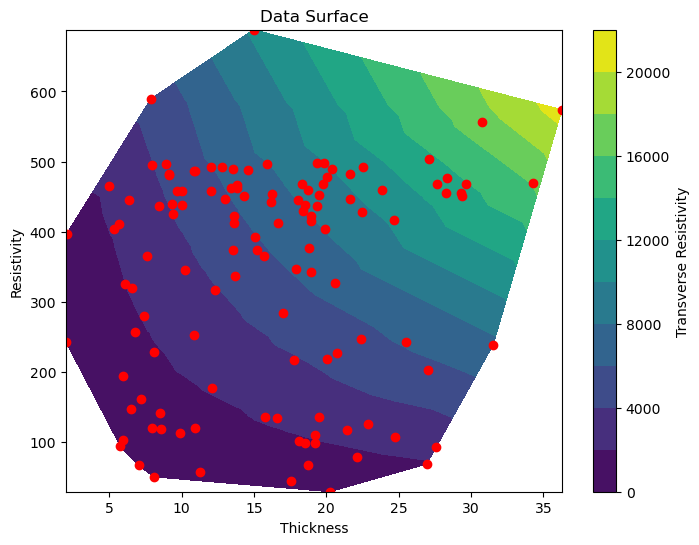

In [12]:
x_grid = x[:, 0]
y_grid = x[:, 1]
Z_grid = y

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(x_grid.ravel(), y_grid.ravel(), Z_grid.ravel(), 
                          levels=10, cmap='viridis') 

plt.colorbar(contour, label='Transverse Resistivity')
plt.scatter(x_grid, y_grid, color='red')
plt.xlabel('Thickness')
plt.ylabel('Resistivity')
plt.title('Data Surface')
plt.show()

Plotting mean rule activation:

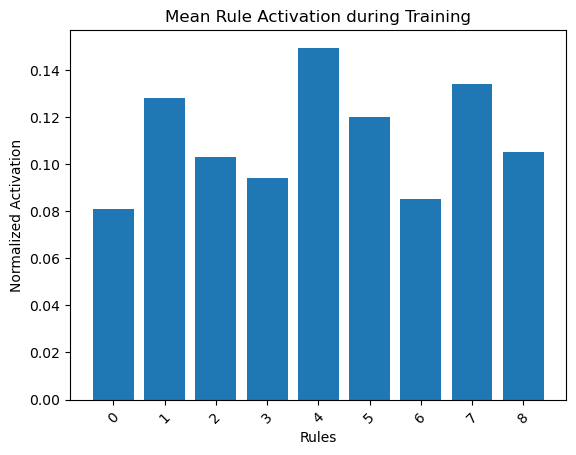

In [13]:
mean_activation = torch.mean(torch.stack(anfis.antecedents.mean_rule_activation, dim=0), dim=0)
mean_activation /= torch.sum(mean_activation)
mean_activation = mean_activation.numpy()

names = [f'{i}' for i in range(9)]

fig, ax = plt.subplots()

ax.bar(names, mean_activation)

ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45)

plt.title('Mean Rule Activation during Training')
plt.xlabel('Rules')
plt.ylabel('Normalized Activation')
plt.show()